
### Introduction

In [ ]:
# general imports
import pandas as pd
import numpy as np
import math

# imports for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# SKlearn distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import cosine_similarity

# SKlearn scalers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

# Sklearn model creation
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# SKlearn vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# SKlearn accuracy evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# SKlearn evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

# SKlearn combinations & gridsearch
from sklearn.model_selection import GridSearchCV
from itertools import combinations

#SKlearn one hot encoder
from sklearn.preprocessing import OneHotEncoder

# SKlearn regressors
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# SKlearn errors
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# time series split, for time-based data
from sklearn.model_selection import TimeSeriesSplit

# SKlearn Clustering
from sklearn.cluster import KMeans
from contextlib import redirect_stderr

# Additional
import random
import warnings
from pandas.tseries.offsets import DateOffset
import statsmodels.api as sm

In [ ]:
def access_excel_from_github(url, sheet_name):
    # Read the Excel file from the URL directly
    df = pd.read_excel(url, sheet_name=sheet_name, engine='openpyxl')
    return df

# Question 2

**Analytical Question**: Looking specifically at microsoft, is it more likely that their stock prices will go up or down in the next month?


**Comments**: This question looks at temporal data. To obtain an in-depth understanding of microsoft, we will be looking at daily data of different financial metrics. From there, we train predictive models to determine whether it is likely that the stock prices increase or decrease in the next month. One month will be taken as 20 trading days.


**Data Used**:  We will be using the original datasets obtained and adding on further quarterly data. The starting dataframe will have 12 base features that we will use for predictions. However, there are many NA values, which may make it necessary to either impute or drop. The features will be a daily time scale over the period of 3 years. We have separate data which is currently stored on a quarterly basis. This will be mapped to a daily basis, then merged with the existing data frame.


**Proposed Solution**: We plan to train 2 classifiers and compare them to each other:

*   Model 1: A multivariate linear regression model
*   Model 2: The K Nearest Neighbors Classifier for values of K which will be optimized using grid search






**Proposed Evaluation**:
We will evaluate the models using the mean squared error.
We will also cross validate the model on 10-fold cross validation, with each fold being around 110 days. Hence the model will be predicting on roughly 4 months of data
Relevant Data
https://github.com/Nayrbnat/DS-112/raw/main/Qn2/Microsoft%20Price%20Ratio%20Data.xlsx
https://github.com/Nayrbnat/DS-112/raw/main/Qn2/Microsoft%20Price%20Ratio%20Data.xlsx


# Microsoft Data

### Pre-processing of data


The data is first pre-processed so that it can be used for analysis. This is done by combining the different quarterly and daily data. The Na values are also dealt with, either by extrapolating or dropping.

In [ ]:
# this function maps data about fiscal quarters to its start date so that it can be merged with daily data

def map_FQ(df, date_header, FQ_dict):
  # map the financial quarters to the start date
  df['Quarter']=df[date_header].str[:3]
  df['Year']=df[date_header].str[4:]
  df['Financial Quarter']=df['Quarter'].map(FQ_dict)

  df['Year'] = df['Year'].astype(int)
  df['FQ Year'] = np.where(
      df['Quarter'].isin(['FQ1', 'FQ2']),
      df['Year'] - 1,
      df['Year']
  )
  df['FQ Year'] = df['FQ Year'].astype(str)

  # output final start date and remove other columns
  df['Date']=df['FQ Year']+df['Financial Quarter']
  df['Date'] = pd.to_datetime(df['Date'])
  df = df.drop(columns =['Pricing Date','Quarter','Year','Financial Quarter','FQ Year'])

  return df

In [ ]:
# retrieve quarterly data and pre-process it to be merged with daily data
q2_microsoft_quarterly_original = access_excel_from_github('https://github.com/Nayrbnat/DS-112/raw/main/Qn2/Microsoft%20Price%20Ratio%20Data.xlsx', 'Quarter')

# use function to process data
FQ_microsoft = {
    'FQ1':'-07-01',
    'FQ2':'-10-01',
    'FQ3':'-01-01',
    'FQ4':'-04-01'
}

q2_microsoft_quarterly = map_FQ(q2_microsoft_quarterly_original, 'Pricing Date', FQ_microsoft)

An important trait about the data we are working with is that it is time-based. The question we are answering is also one about prediction. As such, we need to consider lagged data here. The future data will not be available to make predictions. When doing further analysis later, only the lagged data will be considered and present data will not be considered.

Since the question is asking about predictions for a month later, this is the lagged duration that we are considering. This means that the stock prices for a month later is considered based on all the available information in current time. This prevents data leakage by ensuring that future data is not used to make the prediction.

In [ ]:
# Lag all variables by 1 quarter (3 months)
for col in q2_microsoft_quarterly.columns:
    q2_microsoft_quarterly[col + ' Lagged_m3'] = q2_microsoft_quarterly[col].shift(-1)

# Remove all variables which are not lagged
q2_microsoft_quarterly_merge = q2_microsoft_quarterly.iloc[:,2:].drop(columns='Date Lagged_m3').copy()
q2_microsoft_quarterly_merge.head()

,Date,MSFT-Total Debt/ Total Equity (FQ)(x) Lagged_m3,MSFT-EBIT Margin (FQ)(%) Lagged_m3
0,2024-04-01,0.419961,44.588
1,2024-01-01,0.467679,43.586
2,2023-10-01,0.479308,47.587
3,2023-07-01,0.385733,43.165
4,2023-04-01,0.407842,42.288


In [ ]:
# merge the daily and quarterly data
q2_microsoft_original = access_excel_from_github('https://github.com/Nayrbnat/DS-112/raw/main/Qn2/Microsoft%20Price%20Ratio%20Data.xlsx', 'Daily Data')
q2_microsoft = pd.merge(q2_microsoft_original, q2_microsoft_quarterly_merge, left_on = 'Pricing Date', right_on='Date', how = 'left').drop(columns =['Date'])

# Fill for the previous years
q2_microsoft[['MSFT-Total Debt/ Total Equity (FQ)(x) Lagged_m3','MSFT-EBIT Margin (FQ)(%) Lagged_m3']] = q2_microsoft[['MSFT-Total Debt/ Total Equity (FQ)(x) Lagged_m3','MSFT-EBIT Margin (FQ)(%) Lagged_m3']].bfill()

# Update the latest quarter
starting_date = q2_microsoft_quarterly['Date'].iloc[0] + DateOffset(months=3)
ending_date = q2_microsoft['Pricing Date'].max()
mask = (q2_microsoft['Pricing Date'] >= starting_date) & (q2_microsoft['Pricing Date'] <= ending_date)
q2_microsoft.loc[mask, 'MSFT-Total Debt/ Total Equity (FQ)(x) Lagged_m3'] = q2_microsoft_quarterly['MSFT-Total Debt/ Total Equity (FQ)(x)'].iloc[0]
q2_microsoft.loc[mask, 'MSFT-EBIT Margin (FQ)(%) Lagged_m3'] = q2_microsoft_quarterly['MSFT-EBIT Margin (FQ)(%)'].iloc[0]

# since the market is closed on weekends and public holidays, remove daily data from there
q2_microsoft = q2_microsoft.dropna(subset = ['MSFT-Share Price (Daily)($)'])

# lag all of the daily data by 21 trading days (1 month)
lagged_columns = q2_microsoft.iloc[:, 1:-2].columns
for col in lagged_columns:
    q2_microsoft[col + ' Lagged_m1'] = q2_microsoft[col].shift(-21)

# remove the rows which do not have the lagged variables
q2_microsoft = q2_microsoft.dropna(subset = ['MSFT-Volume (Daily) Lagged_m1','MSFT-EBIT Margin (FQ)(%) Lagged_m3'])

# drop the current data and only focus on lagged variables
q2_microsoft = q2_microsoft.drop(q2_microsoft.iloc[:,2:11].columns, axis=1)

# for use in future time series split, the data should be ordered in ascending order by time
q2_microsoft = q2_microsoft.sort_values('Pricing Date').reset_index(drop=True)

q2_microsoft.head()

,Pricing Date,MSFT-Share Price (Daily)($),MSFT-Total Debt/ Total Equity (FQ)(x) Lagged_m3,MSFT-EBIT Margin (FQ)(%) Lagged_m3,MSFT-Share Price (Daily)($) Lagged_m1,MSFT-Volume (Daily) Lagged_m1,MSFT-TEV/ Forward EBITDA (NTM)(x) Lagged_m1,MSFT-Diluted TEV Outstanding/ FCF Unlevered (LTM)(x) Lagged_m1,MSFT-Forward P/BV (FY+1)(x) Lagged_m1,MSFT-Short Interest Ratio (Daily)(x) Lagged_m1,MSFT-Dividend Yield (Daily)(%) Lagged_m1,MSFT-Beta One Year (Country) Lagged_m1,MSFT-Total Return (Daily)(%) Lagged_m1,MSFT-CIQ Target Price($) Lagged_m1
0,2022-01-03,334.75,0.502062,43.008,329.49,30765980.0,24.054136,47.266412,13.154590,1.274067,0.752678,1.083752,12.934339,364.80622
1,2022-01-04,329.01,0.502062,43.008,323.01,41779280.0,23.570982,46.317013,12.895882,1.126928,0.767778,1.090683,10.713287,365.61703
2,2022-01-05,316.38,0.502062,43.008,326.19,30032560.0,23.808085,46.782922,12.826330,1.138437,0.760293,1.087560,11.803248,365.62711
3,2022-01-06,313.88,0.502062,43.008,334.92,31021940.0,24.459001,48.061973,13.169608,1.339021,0.740475,1.085268,14.795499,365.62711
4,2022-01-07,314.04,0.502062,43.008,334.97,24760990.0,24.462729,48.069299,13.171575,1.465560,0.740365,1.083960,14.812637,365.62711


Next, we will be creating the final data in which the prediction will be made on. This data frame includes the most recent data to predict from, for both daily and quarterly data.

In [ ]:
# retreiving original data
q2_microsoft_quarterly_original

# retain only trading days
q2_microsoft_original = q2_microsoft_original.dropna(subset='MSFT-Share Price (Daily)($)')

# include quarterly data from the most recent FQ
q2_microsoft_original[['MSFT-Total Debt/ Total Equity (FQ)(x)','MSFT-EBIT Margin (FQ)(%)']] = q2_microsoft_quarterly_original.iloc[0, 1:3]

# select only the first 5 training days
X_final_test = q2_microsoft_original.head()

<ipython-input-106-a58426696c3c>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  q2_microsoft_original[['MSFT-Total Debt/ Total Equity (FQ)(x)','MSFT-EBIT Margin (FQ)(%)']] = q2_microsoft_quarterly_original.iloc[0, 1:3]
<ipython-input-106-a58426696c3c>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  q2_microsoft_original[['MSFT-Total Debt/ Total Equity (FQ)(x)','MSFT-EBIT Margin (FQ)(%)']] = q2_microsoft_quarterly_original.iloc[0, 1:3]


## EDA

### EDA: Feature Relationship with Share Price

We'll next be exploring the relationship between each feature and the share price. This is done through a scatter plot.

In [ ]:
# correlation between each feature and share price
df_corr_share = q2_microsoft.iloc[:, 2:].apply(lambda x: q2_microsoft['MSFT-Share Price (Daily)($)'].corr(x))
df_corr_share

,0
MSFT-Total Debt/ Total Equity (FQ)(x) Lagged_m3,-0.274552
MSFT-EBIT Margin (FQ)(%) Lagged_m3,0.601823
MSFT-Share Price (Daily)($) Lagged_m1,0.942877
MSFT-Volume (Daily) Lagged_m1,-0.326130
MSFT-TEV/ Forward EBITDA (NTM)(x) Lagged_m1,0.763049
MSFT-Diluted TEV Outstanding/ FCF Unlevered (LTM)(x) Lagged_m1,0.792755
MSFT-Forward P/BV (FY+1)(x) Lagged_m1,0.397814
MSFT-Short Interest Ratio (Daily)(x) Lagged_m1,0.650577
MSFT-Dividend Yield (Daily)(%) Lagged_m1,-0.775349
MSFT-Beta One Year (Country) Lagged_m1,-0.250991


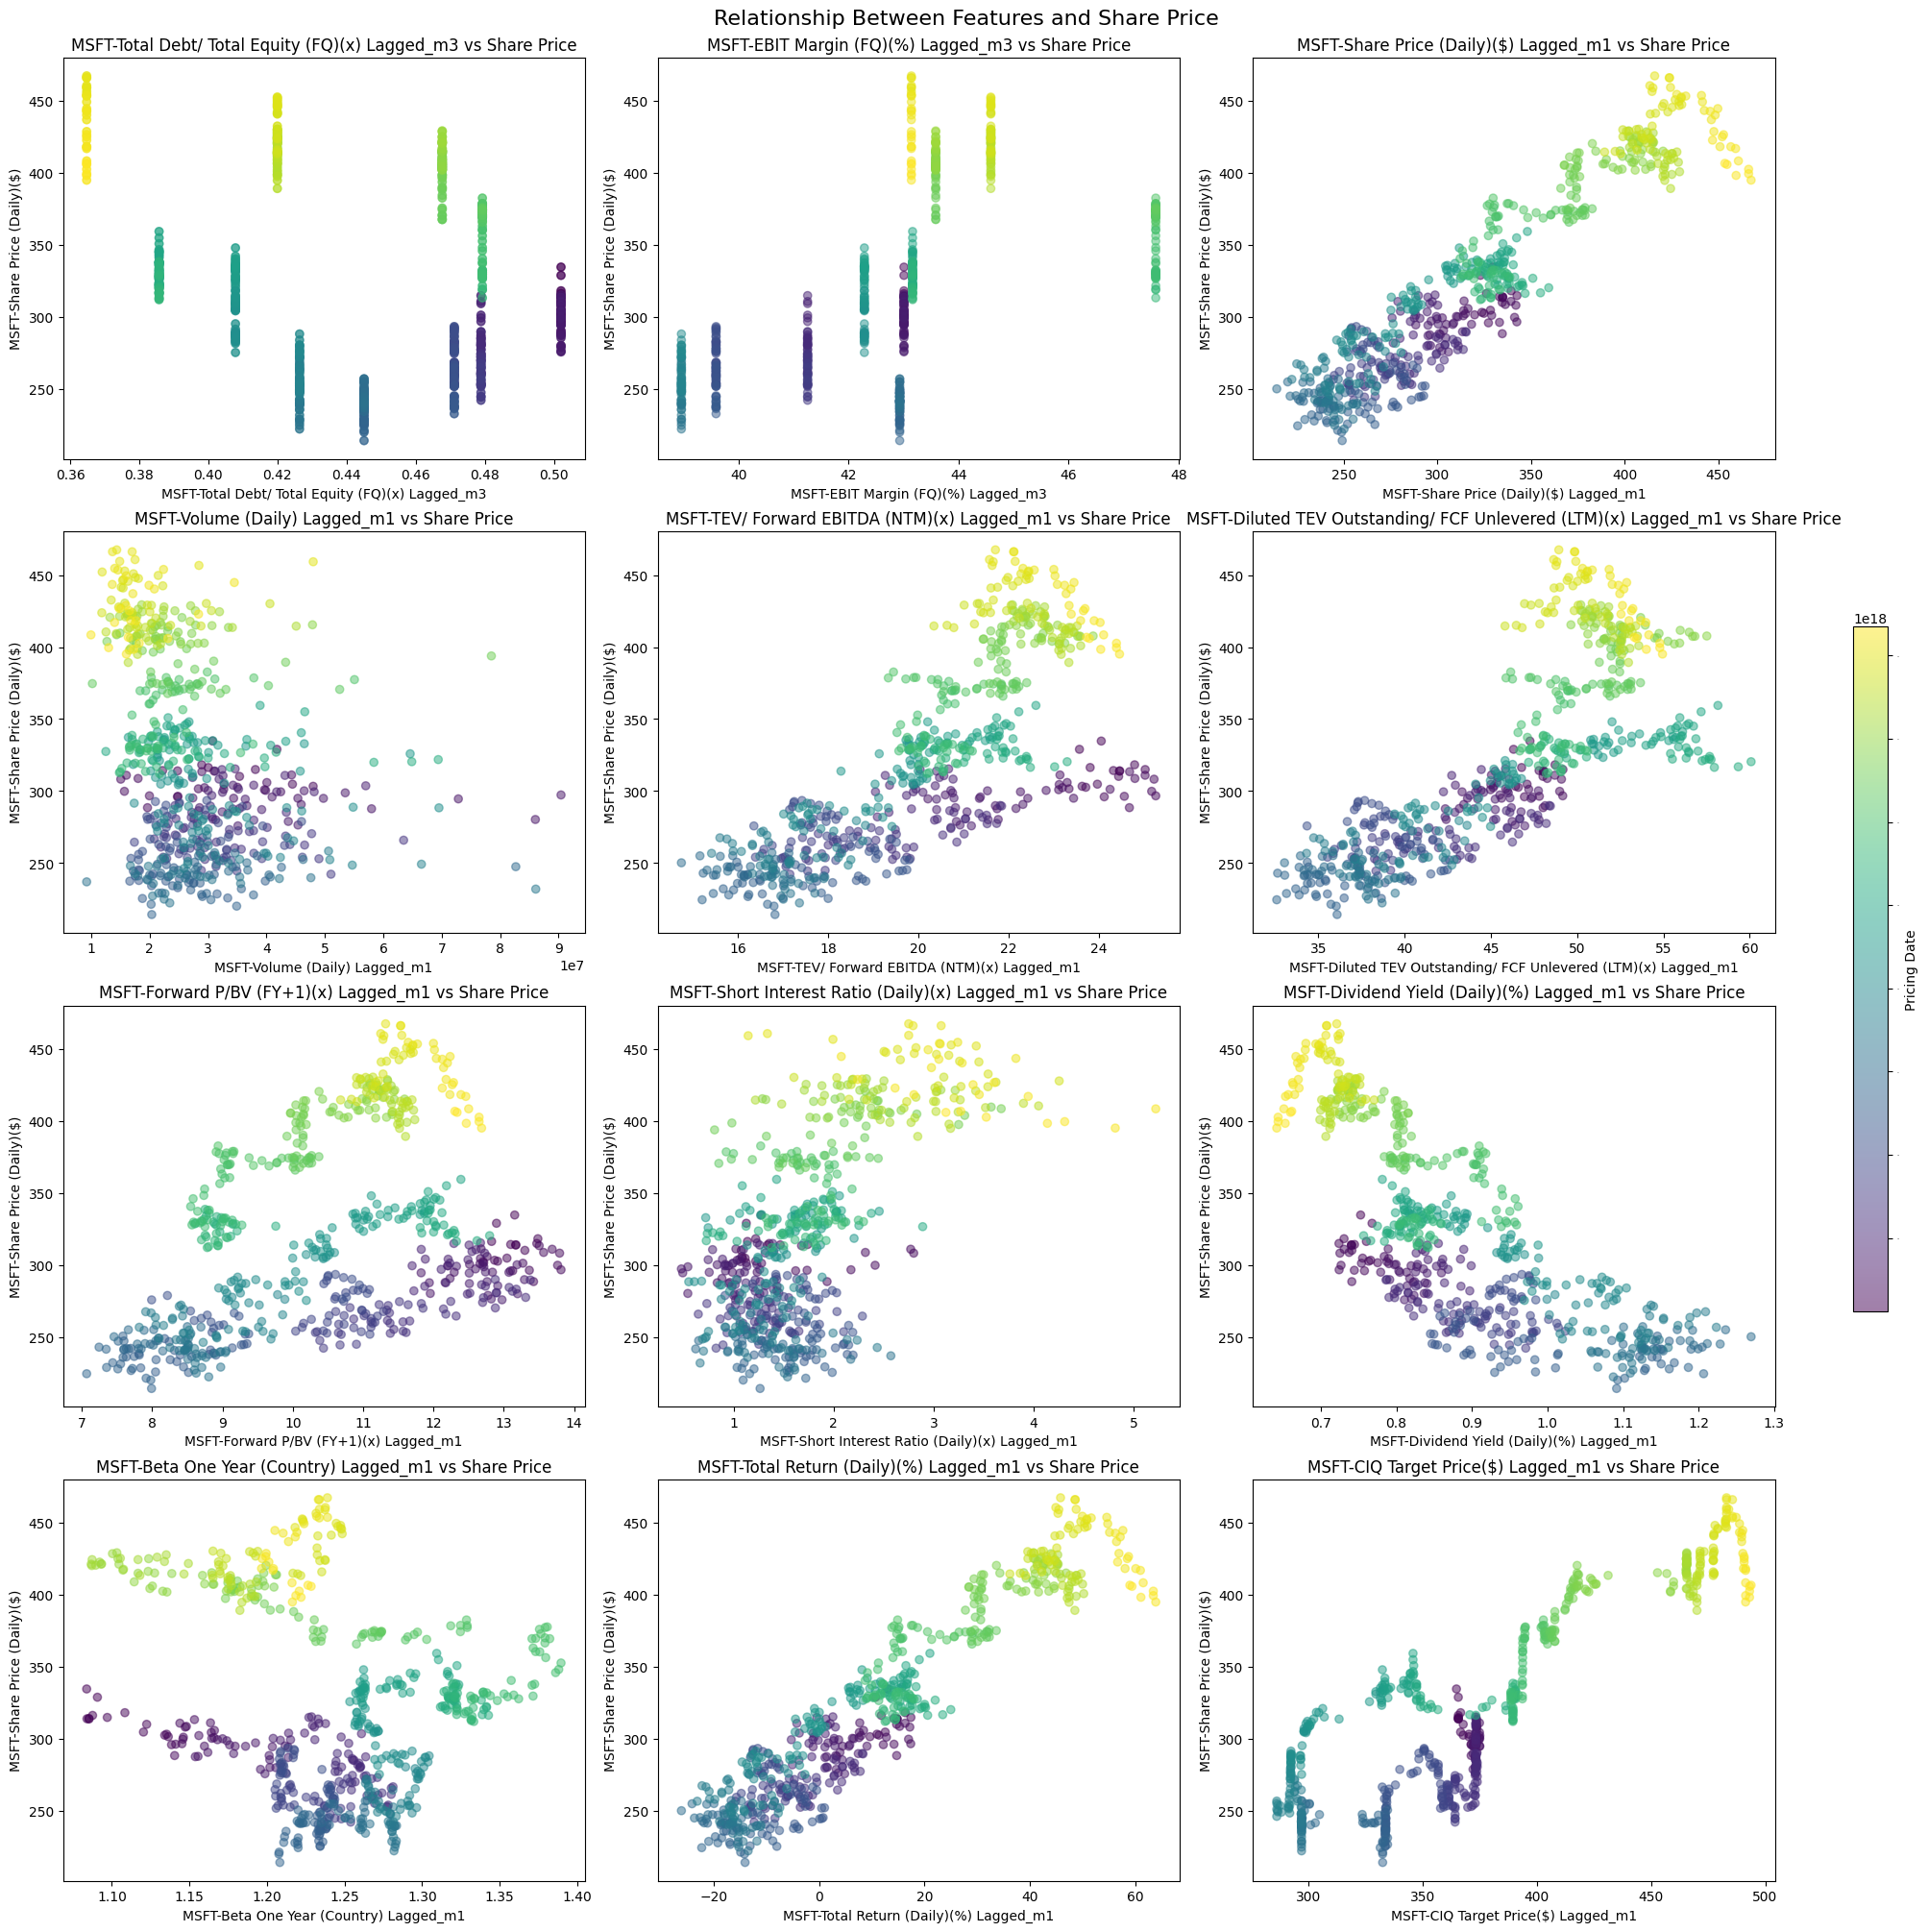

In [ ]:
# Create a grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 20), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Get the feature names from the DataFrame
features = q2_microsoft.iloc[:, 2:].columns

# Create a colormap for the colorbar
cmap = plt.get_cmap('viridis')

# Create a single scatter plot to define the colorbar
scatter = axes[0].scatter(
    x=q2_microsoft[features[0]],
    y=q2_microsoft['MSFT-Share Price (Daily)($)'],
    c=q2_microsoft['Pricing Date'].map(lambda x: x.toordinal()),
    cmap=cmap,
    alpha=0.5
)

# Iterate over each feature and subplot axis to plot scatter plots
for ax, feature in zip(axes, features):
    scatter = ax.scatter(
        x=q2_microsoft[feature],
        y=q2_microsoft['MSFT-Share Price (Daily)($)'],
        c=q2_microsoft["Pricing Date"],
        cmap=cmap,
        alpha=0.5
    )
    ax.set_title(f"{feature} vs Share Price")
    ax.set_xlabel(feature)
    ax.set_ylabel('MSFT-Share Price (Daily)($)')

# Add a common colorbar for the entire figure
cbar = fig.colorbar(scatter, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Pricing Date')
cbar.ax.tick_params(labelsize=0)

# Add a title for the entire figure
fig.suptitle('Relationship Between Features and Share Price', fontsize=16)

# Show the plot
plt.show()


This plot illustrates the relationship between each feature and the share price. There are varying levels of correlation. Most of the data shows a relatively clear positive correlation. On top of that, the data is quite clearly distributed by timing where the share prices have been increasing in recent years.  

There are some other data where the data appears to have a non-linear trend. This EDA tells us that these data can be transformed in the linear regression model to give more accurate insights. These features are 'MSFT-Dividend Yield (Daily)(%) Lagged_m1', 'MSFT-EBIT Margin (FQ)(%) Lagged_m3', 'MSFT-TEV/ Forward EBITDA (NTM)(x) Lagged_m1','MSFT-Diluted TEV Outstanding/ FCF Unlevered (LTM)(x) Lagged_m1'.

### EDA: Feature Distribution

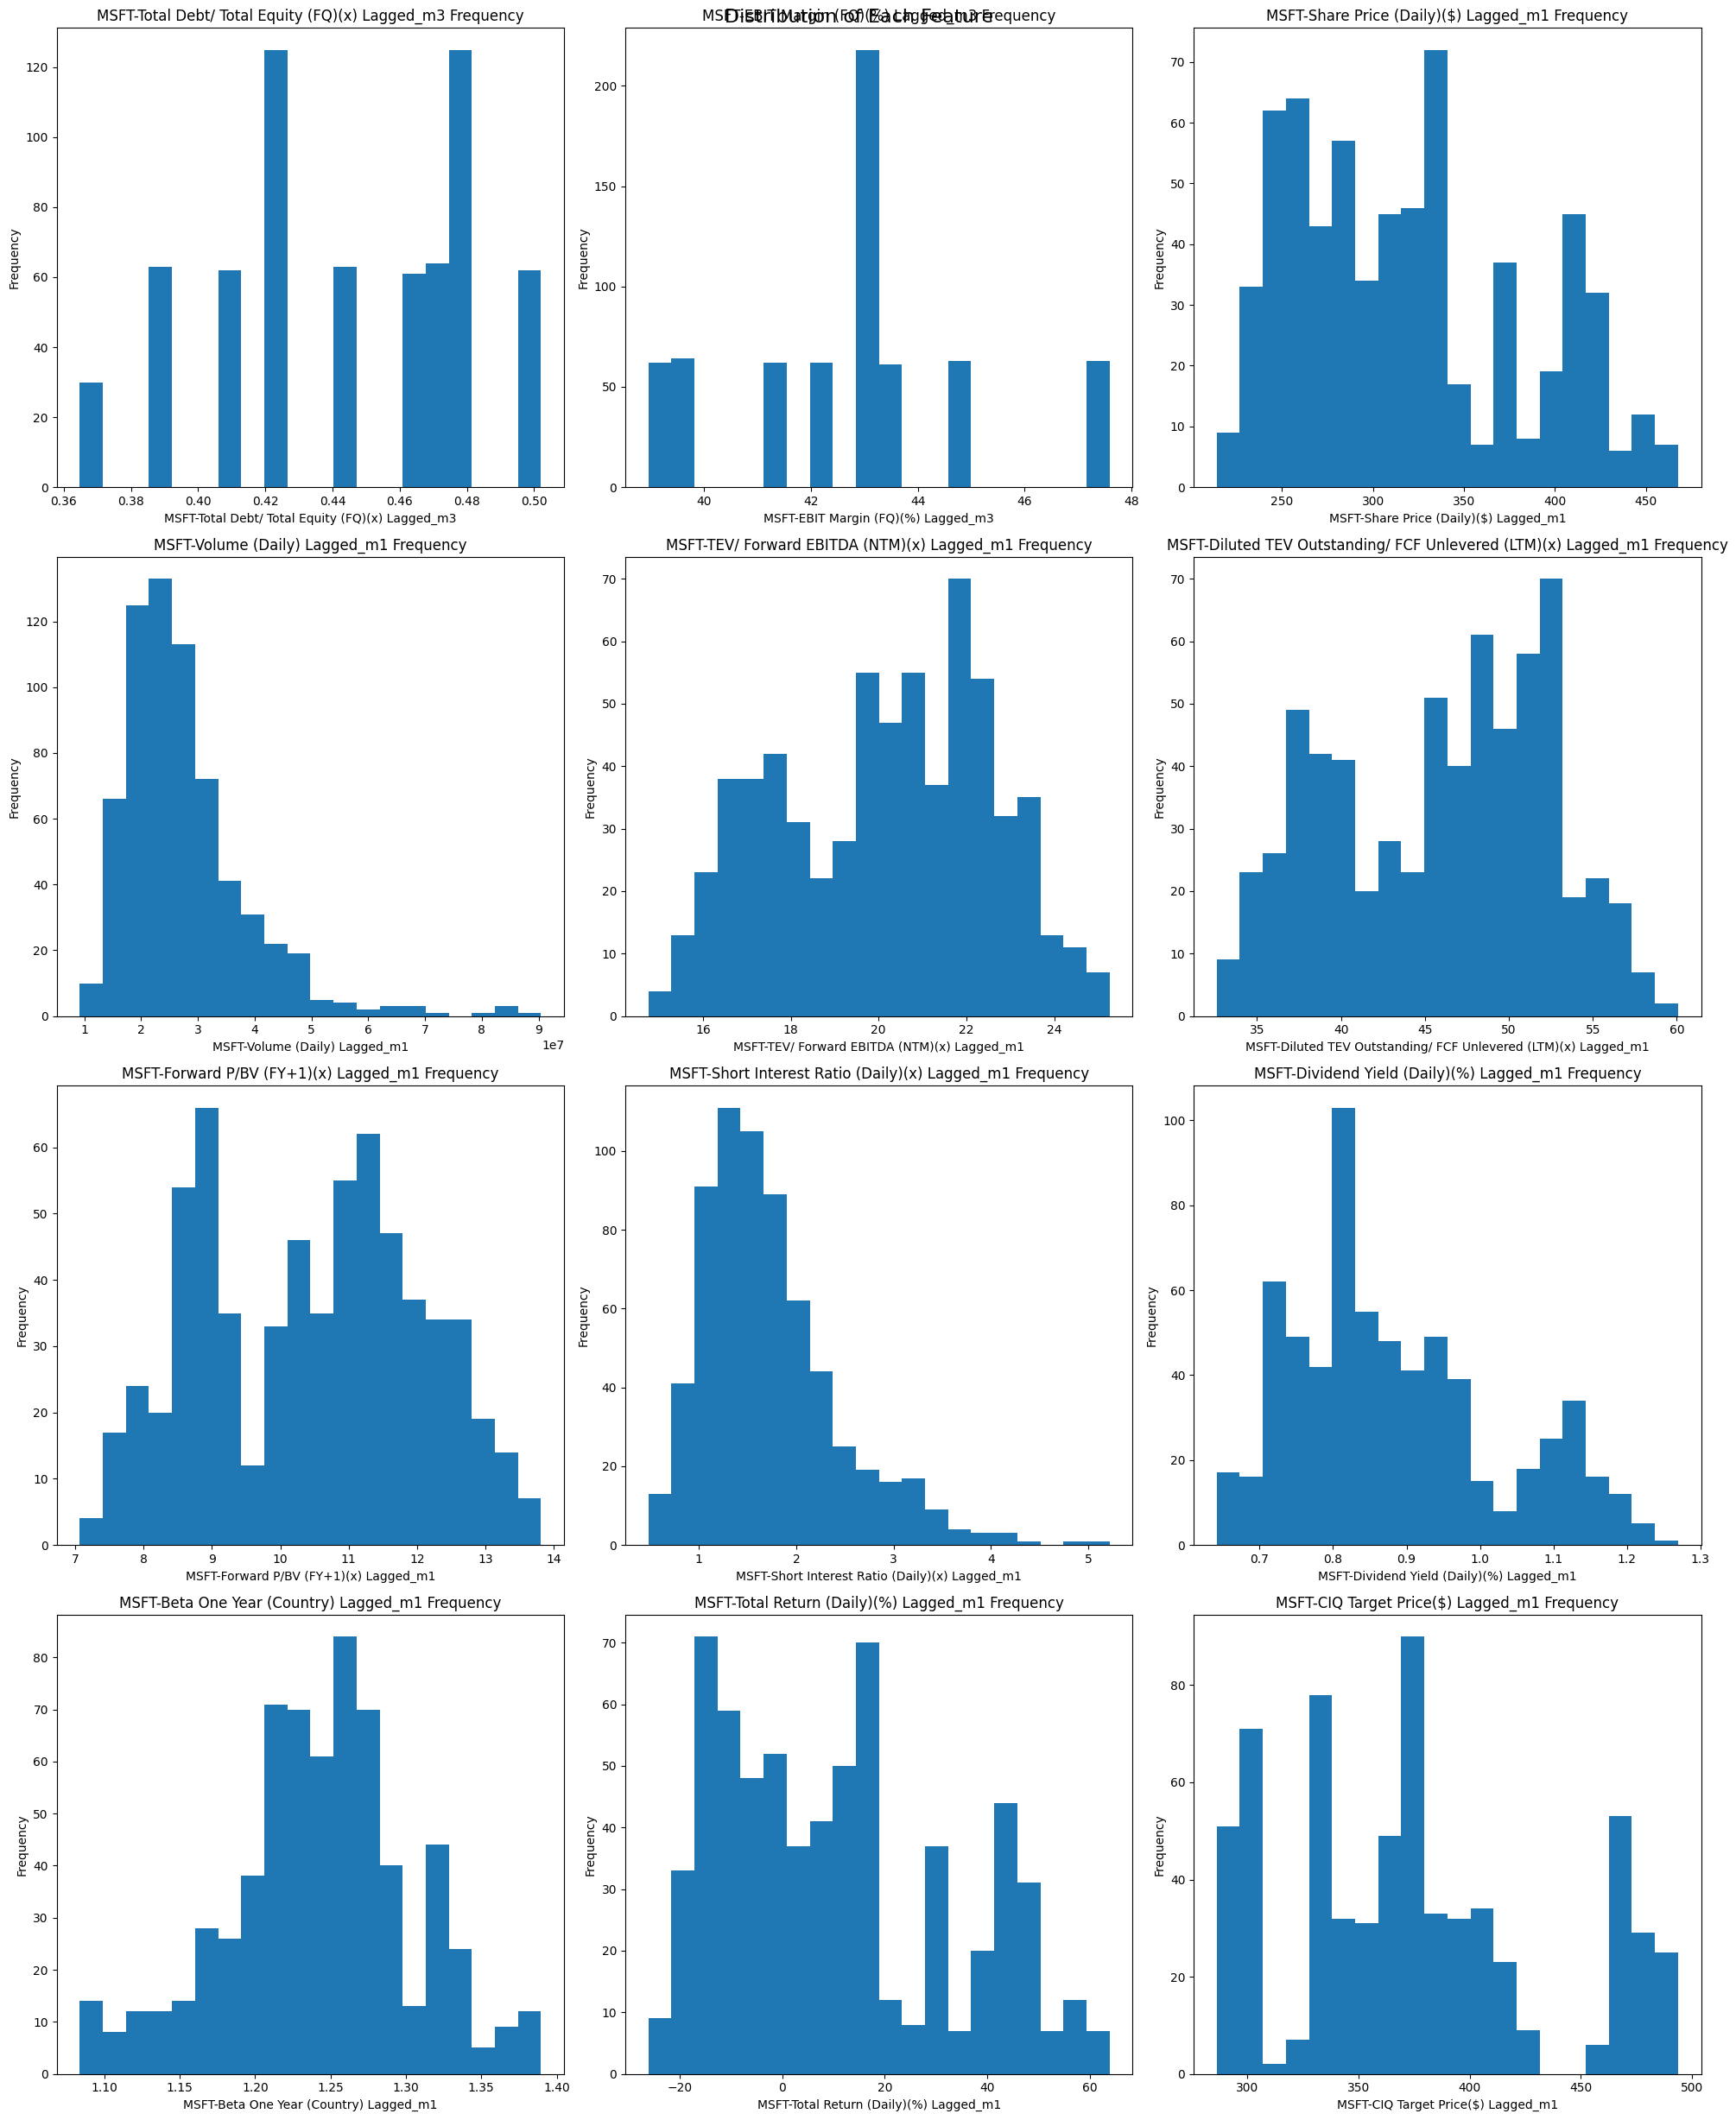

In [ ]:
# Create a grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 25))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Get the feature names from the DataFrame
features = q2_microsoft.iloc[:, 2:].columns

# Iterate over each feature and subplot axis to plot scatter plots
for ax, feature in zip(axes, features):
    scatter = ax.hist(q2_microsoft[feature], bins=20)
    ax.set_title(f"{feature} Frequency")
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

# Add a title for the entire figure
fig.suptitle('Distribution of Each Feature', fontsize=16)
fig.tight_layout()

# Show the plot
plt.show()

This plot shows the distribution of each data. This helps to give insight into how each feature varies. Most of the data does not have drastic outliers and there is no need for them to be eliminated.

From here, we can also infer that the scale of the features are quite different, such as how the target price goes up to 500 while the total debt/total equity all remains under 0.5. Without scaling the data, features such as the ratio between total debt and total equity will be understated, having significantly lower weightage compared to other features. This applies to both the KNN and linear regression model but have an especially large impact on the KNN model. In the KNN model, the similarity between different observations is calculated based on a similarity metric such as cosine similarity, euclidean distance or manhattan distance. However, these distance would be heavily skewed if the features were not scaled.

Linear regression also assumes that features are normally distributed. This is a fair assumption given the distribution of each of the features.

###EDA: Stock Prices

We can also analyse the distribution of stock prices. This tells us more about the degree of the error when it is calculated later or the way ths distribution varies.

Text(0.5, 0, 'Share Price')

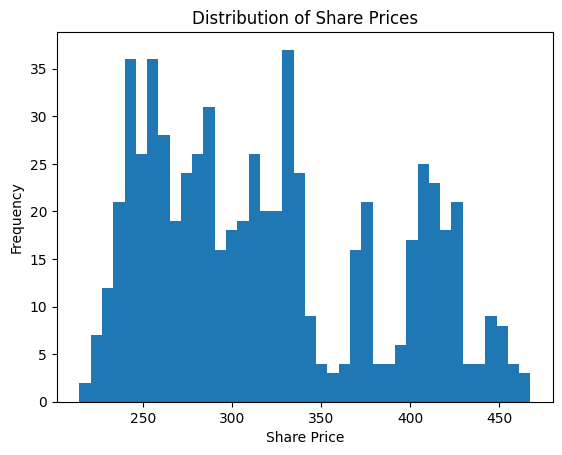

In [ ]:
fig = plt.hist(q2_microsoft['MSFT-Share Price (Daily)($)'], bins=40)

plt.title('Distribution of Share Prices')
plt.ylabel('Frequency')
plt.xlabel('Share Price')

In [ ]:
q2_microsoft['MSFT-Share Price (Daily)($)'].describe()

,MSFT-Share Price (Daily)($)
count,655.000000
mean,321.096115
std,65.228546
min,214.250000
25%,264.590000
50%,310.880000
75%,374.375000
max,467.560000


Here, we see that the share prices are distributed relatively evenly over a range. This is likely due to variation in market conditions. On top of this, the data used also includes data from a significant period of time ago, when the performance of Micorsoft could have been different. This offers insight into the range of the prices. We are also able to determine that there are no drastic outliers, making the data slightly more predictable.

### EDA: Linear Regression Characteristics
As part of the EDA, we will be exploring the role that the different features play in a linear regression. This will be done by running a simple linear regression model and analysing the statistics.

In [ ]:
# Define variables and add constant
X = q2_microsoft.iloc[:, 2:]
y = q2_microsoft['MSFT-Share Price (Daily)($)']
X = sm.add_constant(X,has_constant='add')

# Fit the model
model = sm.OLS(y, X)
results = model.fit()

# Print the summary
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:     MSFT-Share Price (Daily)($)   R-squared:                       0.936
Model:                                     OLS   Adj. R-squared:                  0.934
Method:                          Least Squares   F-statistic:                     776.4
Date:                         Sat, 17 Aug 2024   Prob (F-statistic):               0.00
Time:                                 04:33:53   Log-Likelihood:                -2767.5
No. Observations:                          655   AIC:                             5561.
Df Residuals:                              642   BIC:                             5619.
Df Model:                                   12                                         
Covariance Type:                     nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025  

From the introductory statistics table above, we are able to draw a few conclusions.

Here, the R^2 value is expectedly large because of a few reasons. There is high level of multi-collinearity in the data due to the nature of time-based data and financial data. Hence, it is important that some level of feature selection is done so that features with high levels of multi-collinearity are not selected together.

The high R^2 is not a good indication of model fit. Hence, a more robust methodology would be using time-based cross validation. This will ensure that the data that is being used to train the model is different from the data testing the model.

Instead of using R^2 value, we should be evaluating the model on other metrics, such as RMSE. This is able to give greater insight into the fit of the data and its ability to make predictions.

There are many features with low p value and P > |t| value, indicating that they are statistically significant. Some features that we are further analysing include:


*   MSFT-Beta One Year (Country) Lagged_m1

The negative coefficient suggests that an increase in Microsoft's one-year beta from a month ago is associated with a decrease in the current share price. The low p-value and confidence interval which does not include zero indicates this feature is highly statistically significant, meaning it strongly influences the share price.

*   MSFT-Total Debt/Total Equity (FQ)(x) Lagged_m3

The positive coefficient indicates that an increase in the debt-to-equity ratio three months ago is associated with a higher share price. The confidence interval is entirely positive, confirming the reliability of this feature's positive effect on share price.

In [ ]:
# check for multi-collinearity
df_corr = q2_microsoft.iloc[:, 2:].corr()
df_corr

# create and apply a mask to eliminate the correlation of one variable with itself
mask = np.triu(np.ones_like(df_corr, dtype=bool), k=1)
masked_corr = df_corr.where(mask)
df_corr

,MSFT-Total Debt/ Total Equity (FQ)(x) Lagged_m3,MSFT-EBIT Margin (FQ)(%) Lagged_m3,MSFT-Share Price (Daily)($) Lagged_m1,MSFT-Volume (Daily) Lagged_m1,MSFT-TEV/ Forward EBITDA (NTM)(x) Lagged_m1,MSFT-Diluted TEV Outstanding/ FCF Unlevered (LTM)(x) Lagged_m1,MSFT-Forward P/BV (FY+1)(x) Lagged_m1,MSFT-Short Interest Ratio (Daily)(x) Lagged_m1,MSFT-Dividend Yield (Daily)(%) Lagged_m1,MSFT-Beta One Year (Country) Lagged_m1,MSFT-Total Return (Daily)(%) Lagged_m1,MSFT-CIQ Target Price($) Lagged_m1
MSFT-Total Debt/ Total Equity (FQ)(x) Lagged_m3,1.000000,0.071041,-0.248690,0.209764,-0.045896,-0.276183,0.091381,-0.327681,0.049147,-0.275639,-0.262294,-0.069881
MSFT-EBIT Margin (FQ)(%) Lagged_m3,0.071041,1.000000,0.570375,-0.186043,0.508146,0.560232,0.067360,0.291768,-0.446466,0.105276,0.572675,0.552639
MSFT-Share Price (Daily)($) Lagged_m1,-0.248690,0.570375,1.000000,-0.337552,0.872402,0.835817,0.509869,0.691085,-0.889387,-0.321681,0.999721,0.913533
MSFT-Volume (Daily) Lagged_m1,0.209764,-0.186043,-0.337552,1.000000,-0.205853,-0.228157,0.044661,-0.694962,0.235818,0.011658,-0.342933,-0.310931
MSFT-TEV/ Forward EBITDA (NTM)(x) Lagged_m1,-0.045896,0.508146,0.872402,-0.205853,1.000000,0.881482,0.735138,0.473699,-0.935514,-0.346321,0.863073,0.723924
MSFT-Diluted TEV Outstanding/ FCF Unlevered (LTM)(x) Lagged_m1,-0.276183,0.560232,0.835817,-0.228157,0.881482,1.000000,0.567817,0.447668,-0.827350,-0.037167,0.833984,0.616038
MSFT-Forward P/BV (FY+1)(x) Lagged_m1,0.091381,0.067360,0.509869,0.044661,0.735138,0.567817,1.000000,0.178618,-0.737857,-0.428920,0.493512,0.448074
MSFT-Short Interest Ratio (Daily)(x) Lagged_m1,-0.327681,0.291768,0.691085,-0.694962,0.473699,0.447668,0.178618,1.000000,-0.518443,-0.229620,0.696178,0.660351
MSFT-Dividend Yield (Daily)(%) Lagged_m1,0.049147,-0.446466,-0.889387,0.235818,-0.935514,-0.827350,-0.737857,-0.518443,1.000000,0.355332,-0.880197,-0.824868
MSFT-Beta One Year (Country) Lagged_m1,-0.275639,0.105276,-0.321681,0.011658,-0.346321,-0.037167,-0.428920,-0.229620,0.355332,1.000000,-0.311708,-0.387879


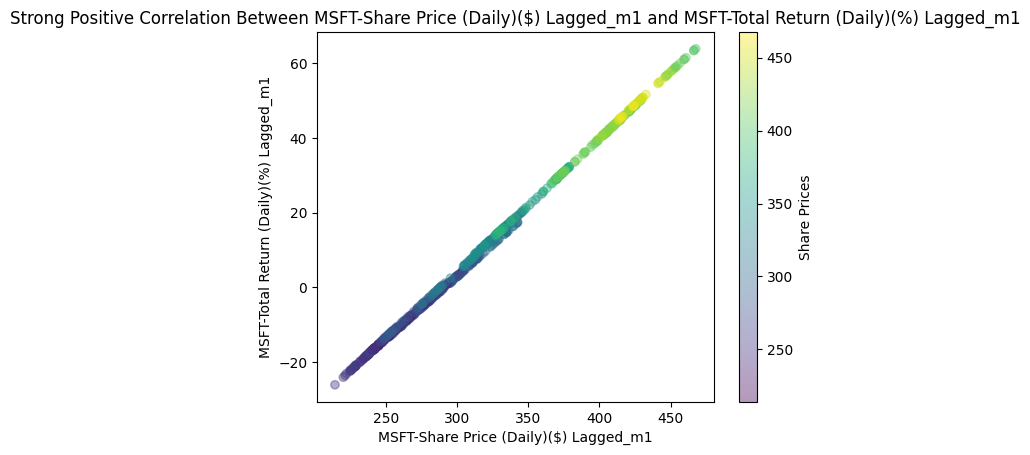

The correlation value between the two features are 0.9997207399731896.


In [ ]:
# Find and plot the visualisation of the index of the most positive correlation value
max_corr_value = masked_corr.max().max()
max_corr_idx = masked_corr.stack()[masked_corr.stack() == max_corr_value].index

# identify the features
feature1 = max_corr_idx[0][0]
feature2 = max_corr_idx[0][1]

fig = plt.scatter(x=q2_microsoft[feature1], y=q2_microsoft[feature2], c=q2_microsoft['MSFT-Share Price (Daily)($)'], alpha=0.4)

# label the diagram
plt.title(f'Strong Positive Correlation Between {feature1} and {feature2}')
plt.xlabel(feature1)
plt.ylabel(feature2)

Cbar = plt.colorbar()
Cbar.set_label('Share Prices')

plt.show()
print(f"The correlation value between the two features are {max_corr_value}.")

There is a strong positive correlation between Daily Share Price and Daily Total Return. This is expected as the total return is calculated based on the share prices of the day itself and the day before.

The strong correlation is an indicator that if both of these features were to be used as predictors in the linear regression model, it is likely that the effects of the predictors will be understated or overstated. Hence, when building the linear regression model, these features should not be used concurrently.

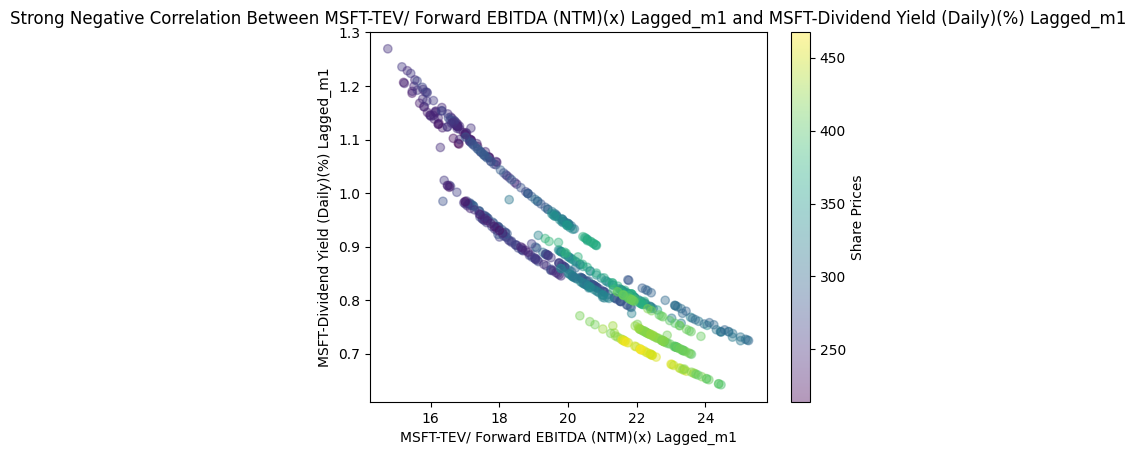

The correlation value between the two features are -0.9355141335372287.


In [ ]:
# Find and plot the visualisation of the index of the most negative correlation value
min_corr_value = masked_corr.min().min()
min_corr_idx = masked_corr.stack()[masked_corr.stack() == min_corr_value].index

feature1 = min_corr_idx[0][0]
feature2 = min_corr_idx[0][1]

fig = plt.scatter(x=q2_microsoft[feature1], y=q2_microsoft[feature2], c=q2_microsoft['MSFT-Share Price (Daily)($)'], alpha=0.4)

plt.title(f'Strong Negative Correlation Between {feature1} and {feature2}')
plt.xlabel(feature1)
plt.ylabel(feature2)

Cbar = plt.colorbar()
Cbar.set_label('Share Prices')

plt.show()
print(f"The correlation value between the two features are {min_corr_value}.")

There is also a strong negative correlation between TEV/Forward EBITDA and Dividend Yield. This also suggests that both features should not be used together as predictors.

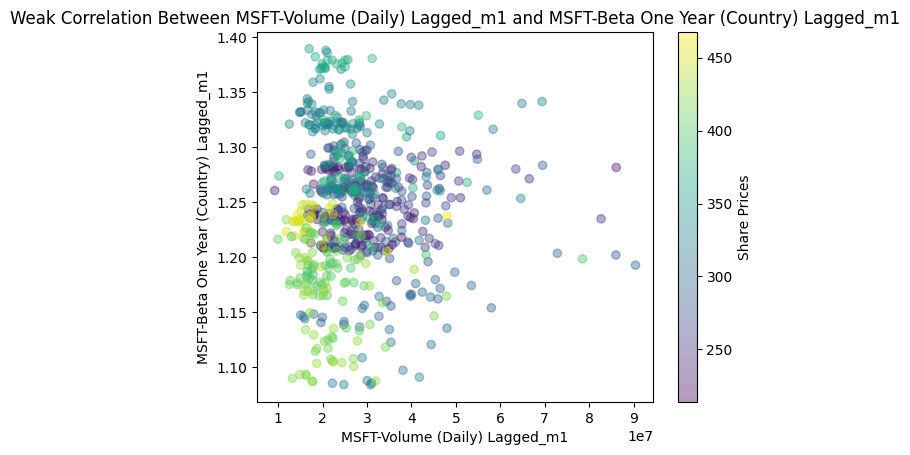

The correlation value between the two features are 0.011657585229059114.


In [ ]:
# Find and plot the visualisation of the index of the weakest correlation value
weak_corr_value = masked_corr.abs().min().min()
weak_corr_idx = masked_corr.stack()[masked_corr.stack() == weak_corr_value].index

feature1 = weak_corr_idx[0][0]
feature2 = weak_corr_idx[0][1]

fig = plt.scatter(x=q2_microsoft[feature1], y=q2_microsoft[feature2], c=q2_microsoft['MSFT-Share Price (Daily)($)'], alpha=0.4)

plt.title(f'Weak Correlation Between {feature1} and {feature2}')
plt.xlabel(feature1)
plt.ylabel(feature2)

Cbar = plt.colorbar()
Cbar.set_label('Share Prices')

plt.show()
print(f"The correlation value between the two features are {weak_corr_value}.")

The correlation value between the two features is relatively low. This implies a low covariance and, hence, relative independence of the two features. Hence, the two features predict different aspects of the share price and do not face collinearity, making them viable options for features considered together in a linear regression model.

In [ ]:
# from the above analysis, we are narrowing the feature selection by detecting multi-collinearity

selected_features = q2_microsoft.iloc[:, 2:].columns

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(q2_microsoft[selected_features], i) for i in range(len(selected_features))]

vif_df = pd.DataFrame(vif, columns =['vif'])
vif_df['features']=selected_features
vif_df.set_index('features')

,vif
features,
MSFT-Total Debt/ Total Equity (FQ)(x) Lagged_m3,347.279649
MSFT-EBIT Margin (FQ)(%) Lagged_m3,1208.537615
MSFT-Share Price (Daily)($) Lagged_m1,9124.581997
MSFT-Volume (Daily) Lagged_m1,16.883462
MSFT-TEV/ Forward EBITDA (NTM)(x) Lagged_m1,1923.034459
MSFT-Diluted TEV Outstanding/ FCF Unlevered (LTM)(x) Lagged_m1,758.726128
MSFT-Forward P/BV (FY+1)(x) Lagged_m1,219.112720
MSFT-Short Interest Ratio (Daily)(x) Lagged_m1,30.873371
MSFT-Dividend Yield (Daily)(%) Lagged_m1,739.349664


MSFT-Volume (Daily) Lagged_m1	has the lowest level of multi-collinearity, making it an ideal feature to be used in the model.

## Model Creation & Evaluation

### Linear Regression Model

#### First Iteration of Model

Due to the high computational power needed to tune the model, we'll be taking a one-at-a-time approach. This will be done by first looking at the different scaling techniques which can be used, creating the data using all available features.

In [ ]:
# First, deduce the best means of scaling

pipeline = make_pipeline(StandardScaler(), LinearRegression())

# since this data is time-based, it is important to use TSCV to avoid data leakage
tscv = TimeSeriesSplit(n_splits=10)

X = q2_microsoft.iloc[:, 13:]
y = q2_microsoft['MSFT-Share Price (Daily)($)']

param_grid = {
    'standardscaler': [StandardScaler(), MinMaxScaler(), Normalizer()]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_root_mean_squared_error')
grid_search.fit(X, y)

rmse_scaler = -grid_search.best_score_

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {-grid_search.best_score_}')

Best Parameters: {'standardscaler': StandardScaler()}
Best Score: 40.00946081579954


In [ ]:
# since the best scaler is standard scaler, we'll be further tuning the model

# since this data is time-based, it is important to use TSCV to avoid data leakage
tscv = TimeSeriesSplit(n_splits=10)

param_grid = {
    'standardscaler__with_mean': [True, False],
    'standardscaler__with_std': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_root_mean_squared_error')
grid_search.fit(X, y)

rmse_mean_std = -grid_search.best_score_

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {-grid_search.best_score_}')

Best Parameters: {'standardscaler__with_mean': False, 'standardscaler__with_std': False}
Best Score: 40.009460815799535


#### Second iteration of model - features

In the second iteration of the model, we'll be using the features as part of the analysis. From the analysis above, we'll be transforming some features since it appears to have a non-linear relationship with share price. We'll also be changing the feature selection, to avoid multi-collinearity.

In [ ]:
# we conclude the best scaler and create a new pipeline
# we then test different inputs and feature combinations

pipeline = make_pipeline(StandardScaler(with_mean=False, with_std=False), LinearRegression())

def tscv_cross_val(pipeline,X,y):
  total_rmse = 0
  count = 0

  for train_index, test_index in tscv.split(X):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      pipeline.fit(X_train, y_train)
      predictions = pipeline.predict(X_test)
      rmse = math.sqrt(mean_squared_error(y_test, predictions))
      total_rmse += rmse
      count += 1

  avg_rmse = total_rmse/count
  return avg_rmse

Next, we will infer the features which have a non-linear pattern from the EDA. Then, we will try to transform them.

In [ ]:
edit_features = [ 'MSFT-Dividend Yield (Daily)(%) Lagged_m1', 'MSFT-EBIT Margin (FQ)(%) Lagged_m3', 'MSFT-TEV/ Forward EBITDA (NTM)(x) Lagged_m1','MSFT-Diluted TEV Outstanding/ FCF Unlevered (LTM)(x) Lagged_m1']
q2_microsoft_edited = q2_microsoft.copy()

for feature in edit_features:
  q2_microsoft_edited[f'edited {feature}'] = np.log(q2_microsoft_edited[feature])

q2_microsoft_edited = q2_microsoft_edited.drop(columns=edit_features)

In [ ]:
X = q2_microsoft_edited.iloc[:, 2:]
y = q2_microsoft_edited['MSFT-Share Price (Daily)($)']

rmse_transformed = tscv_cross_val(pipeline,X,y)
print(rmse_transformed)

34.118702289609175


Next, we will try to do feature selection by decreasing and trying different combinations of features. To select the features to be used, we refer back to our EDA and pick out the features that are statistically significant. This is because it is too computationally challenging to try all combinations of all features and it is more possible to first narrow it down to fewer features.

We take the 4 features with the smallest p > |t| and lower multi-collinearity.

In [ ]:
selected_features =['MSFT-Volume (Daily) Lagged_m1',
'MSFT-Beta One Year (Country) Lagged_m1',
'MSFT-Total Debt/ Total Equity (FQ)(x) Lagged_m3',
'MSFT-CIQ Target Price($) Lagged_m1']
from tqdm.notebook import tqdm
import time

for i in tqdm(range(100)):
    time.sleep(0.1)

    lowest_error = float("inf")
    features = selected_features
    best_features = None

    for feature in features:
      X = q2_microsoft[[feature]]
      y = q2_microsoft['MSFT-Share Price (Daily)($)']
      rmse = tscv_cross_val(pipeline, X, y)
      if rmse < lowest_error:
        lowest_error = rmse
        best_features = feature

    for size in range(2, len(features) + 1):
      for feature in combinations(features, size):
        feature_string = ",".join(feature)
        X = q2_microsoft[list(feature)]
        y = q2_microsoft['MSFT-Share Price (Daily)($)']
        rmse = tscv_cross_val(pipeline, X, y)
        if rmse < lowest_error:
          lowest_error = rmse
          best_features = feature

rmse_feature = lowest_error
print(best_features)
print(lowest_error)

  0%|          | 0/100 [00:00<?, ?it/s]

('MSFT-Volume (Daily) Lagged_m1', 'MSFT-CIQ Target Price($) Lagged_m1')
39.79199649557807


#### Model Evaluation

In [ ]:
data = {
    'Name': ['rmse_scaler', 'rmse_mean_std', 'rmse_transformed', 'rmse_feature'],
    'Value': [rmse_scaler, rmse_mean_std, rmse_transformed, rmse_feature]
}

df_rmse = pd.DataFrame(data)
df_rmse.set_index('Name')

,Value
Name,
rmse_scaler,40.009461
rmse_mean_std,40.009461
rmse_transformed,34.118702
rmse_feature,39.791996


From this, we can conclude that the best linear model are the ones with the variables transformed.

### KNN Model
We will first be finding the best hyperparameters of the KNN model using grid search. This iterates through the different hyperparameters and finds the ideal model.
After finding the ideal model, we will do some feature selection. Based on the linear regression model, there was increased accuracy when selecting features, compared to no features being selected. Hence, a few features are selected and tested to find the best combination.

In [ ]:
# First, deduce the best means of scaling

pipeline = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=5, metric='Euclidean'))

# since this data is time-based, it is important to use TSCV to avoid data leakage
tscv = TimeSeriesSplit(n_splits=10)

X = q2_microsoft.iloc[:, 13:]
y = q2_microsoft['MSFT-Share Price (Daily)($)']

param_grid = {"kneighborsregressor__n_neighbors": range(1, 60),
"kneighborsregressor__metric": ["euclidean", "manhattan", "cosine"],
'kneighborsregressor__weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_root_mean_squared_error')
grid_search.fit(X, y)

rmse_knn_param = -grid_search.best_score_
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {-grid_search.best_score_}')

Best Parameters: {'kneighborsregressor__metric': 'euclidean', 'kneighborsregressor__n_neighbors': 8, 'kneighborsregressor__weights': 'uniform'}
Best Score: 28.265720896283757


After evaluating the best possible model, in terms of hyperparameter tuning, we will be changing the features used in the model to find the best combination. If computational power permits, it would be ideal to combine and permutate all of the features to find the best possible model.

In [ ]:
md = grid_search.best_estimator_

from tqdm.notebook import tqdm
import time

for i in tqdm(range(100)):
    time.sleep(0.1)

    lowest_error = float("inf")
    features = selected_features
    best_features = None

    for feature in features:
      X = q2_microsoft[[feature]]
      y = q2_microsoft['MSFT-Share Price (Daily)($)']
      rmse = tscv_cross_val(md, X, y)
      if rmse < lowest_error:
        lowest_error = rmse
        best_features = feature

    for size in range(2, len(features) + 1):
      for feature in combinations(features, size):
        feature_string = ",".join(feature)
        X = q2_microsoft[list(feature)]
        y = q2_microsoft['MSFT-Share Price (Daily)($)']
        rmse = tscv_cross_val(md, X, y)
        if rmse < lowest_error:
          lowest_error = rmse
          best_features = feature

rmse_knn_feature = lowest_error
print(best_features)
print(lowest_error)

  0%|          | 0/100 [00:00<?, ?it/s]

('MSFT-Total Debt/ Total Equity (FQ)(x) Lagged_m3', 'MSFT-CIQ Target Price($) Lagged_m1')
27.51638739614354


### Model Evaluation

RMSE is chosen for two reasons. Firsly, for its sensitivity to large errors. RMSE gives higher weight to larger errors, which is particularly important in financial contexts. Large deviations can have significant financial implications, and RMSE helps to capture and penalize these large errors more effectively than other metrics like MAE (Mean Absolute Error).

Secondly, RMSE is expressed in the same units as the target variable, share prices in this case. This makes it easier to interpret the magnitude of errors directly. From the previous EDA, we have concluded that the mean of the stock prices is 321.096115. We can use this to consider how accurate the model is and how large the deviation is.

In [ ]:
data = {
    'Name': ['rmse_scaler', 'rmse_mean_std', 'rmse_transformed', 'rmse_feature', 'rmse_knn_param', 'rmse_knn_feature'],
    'Value': [rmse_scaler, rmse_mean_std, rmse_transformed, rmse_feature, rmse_knn_param, rmse_knn_feature]
}

df_rmse = pd.DataFrame(data)
df_rmse.set_index('Name')

,Value
Name,
rmse_scaler,40.009461
rmse_mean_std,40.009461
rmse_transformed,34.118702
rmse_feature,39.791996
rmse_knn_param,28.265721
rmse_knn_feature,27.516387


From evaluating the rmse values of the different models, it can be concluded that the best model is the KNN model, with specific features and hyperparameters tuned. Considering that the error is less than 10% of the mean, it is relatively accurate at predicting the stock prices.

We will now be running further evaluations of it to understand the model.

In [ ]:
# define pipeline
pipeline_best = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=8, metric='euclidean', weights='uniform'))

# define X and y
X = q2_microsoft[list(best_features)]
y = q2_microsoft['MSFT-Share Price (Daily)($)']

# fit pipeline
pipeline_best.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsregressor',
                 KNeighborsRegressor(metric='euclidean', n_neighbors=8))])

Text(0, 0.5, 'predicted share price')

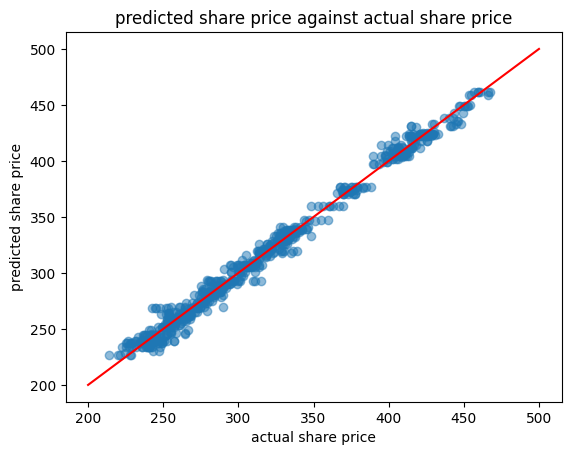

In [ ]:
# finding the different errors of the model
plt.scatter(x=y, y=pipeline_best.predict(X), alpha=0.5)
plt.plot([200, 500], [200, 500], color='red')

plt.title('predicted share price against actual share price')
plt.xlabel('actual share price')
plt.ylabel('predicted share price')

The red line is the ideal prediction. This diagram shows how the predictions by the model deviates from the actual share price. There does not apppear to be a clear trend in the mistakes made by the predictive model.

In [ ]:
X = q2_microsoft[list(best_features)]
y = q2_microsoft['MSFT-Share Price (Daily)($)']

In [ ]:
# finding the different errors of the model, using cross validation
train_rmse_scores = []
test_rmse_scores = []
train_mse_scores = []
test_mse_scores = []
train_mae_scores = []
test_mae_scores = []

# Manual cross-validation loop
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    pipeline_best.fit(X_train, y_train)

    # Predict on both training and testing data
    y_train_pred = pipeline_best.predict(X_train)
    y_test_pred = pipeline_best.predict(X_test)

    # Calculate training errors
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)

    # Calculate testing errors
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # Append errors to lists
    train_mse_scores.append(train_mse)
    train_rmse_scores.append(train_rmse)
    train_mae_scores.append(train_mae)

    test_mse_scores.append(test_mse)
    test_rmse_scores.append(test_rmse)
    test_mae_scores.append(test_mae)

# Calculate the average scores
average_train_mse = np.mean(train_mse_scores)
average_train_rmse = np.mean(train_rmse_scores)
average_train_mae = np.mean(train_mae_scores)

average_test_mse = np.mean(test_mse_scores)
average_test_rmse = np.mean(test_rmse_scores)
average_test_mae = np.mean(test_mae_scores)

# Output the average results
print("Average Training MSE:", average_train_mse)
print("Average Training RMSE:", average_train_rmse)
print("Average Training MAE:", average_train_mae)

print("Average Testing MSE:", average_test_mse)
print("Average Testing RMSE:", average_test_rmse)
print("Average Testing MAE:", average_test_mae)

Average Training MSE: 55.02145938129422
Average Training RMSE: 7.374588579644981
Average Training MAE: 5.705530828078958
Average Testing MSE: 1136.648993752648
Average Testing RMSE: 27.51638739614354
Average Testing MAE: 23.148213983050844


This gives us the training and test error for the model, with different error metrics. There are some notable points.

There is a large difference between between the training and testing error. This implies that the model is overfitting the data, causing a large testing error. This is likely because the ideal model is a KNN model which is non-parametric.

The RMSE is also larger than the MAE. This implies that the errors are caused by large deviation from the actual value (magnitude of error) rather than number of errors.

## Final Prediction

Finally, we'll be using the optimal model found and the most recent data to make a prediction about the stock prices in the next month.

In [ ]:
# define variables for prediction, exclude the last variable to prevent overlap of training and testing data
best_features = list(best_features)
X = q2_microsoft[best_features].iloc[:-1]
y = q2_microsoft['MSFT-Share Price (Daily)($)'].iloc[:-1]

In [ ]:
# edit test data to have the same column headers
X_test = X_final_test[['MSFT-Total Debt/ Total Equity (FQ)(x)',
 'MSFT-CIQ Target Price($)']]
X_test.rename(columns={'MSFT-Total Debt/ Total Equity (FQ)(x)': 'MSFT-Total Debt/ Total Equity (FQ)(x) Lagged_m3', 'MSFT-CIQ Target Price($)': 'MSFT-CIQ Target Price($) Lagged_m1'}, inplace=True)

<ipython-input-133-b8ff30f1a6f8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.rename(columns={'MSFT-Total Debt/ Total Equity (FQ)(x)': 'MSFT-Total Debt/ Total Equity (FQ)(x) Lagged_m3', 'MSFT-CIQ Target Price($)': 'MSFT-CIQ Target Price($) Lagged_m1'}, inplace=True)


In [ ]:
# fit using all available data and predict
pipeline_best.fit(X, y)
prediction = float(pipeline_best.predict(X_test.head(1)))
print("Our Best Model's Final Prediction:",prediction)

Our Best Model's Final Prediction: 405.73125


<ipython-input-134-9340613d9142>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction = float(pipeline_best.predict(X_test.head(1)))


In [ ]:
# find current price
current_price = X_final_test.loc[1,'MSFT-Share Price (Daily)($)']
current_price

406.81

In [ ]:
if prediction > current_price:
    print("Microsoft Share Price went up")
else:
    print("Microsoft Share Price did not go up")

Microsoft Share Price did not go up


# Conclusion

The final conclusion drawn from our model is that the share price of Microsoft, one month from now, is likely to decrease. This conclusion is drawn from comparing the prediction to the current price.

Only time can tell if this is true! We will keep you updated on the final result!

This question was tackled using a regression method, to predict the share price one month from currently. The prediction is made using the model which is found to be the most ideal, with the lowest RMSE. The two main models used is the linear regression and KNN model. For each of these models, the most effective one was found by tuning hyperparameters and the feature

In [ ]:
# @markdown Run this cell to download this notebook as a webpage, `_NOTEBOOK.html`.

import google, json, nbformat

# Get the current notebook and write it to _NOTEBOOK.ipynb
raw_notebook = google.colab._message.blocking_request("get_ipynb",
                                                      timeout_sec=30)["ipynb"]
with open("_NOTEBOOK.ipynb", "w", encoding="utf-8") as ipynb_file:
  ipynb_file.write(json.dumps(raw_notebook))

# Use nbconvert to convert .ipynb to .html.
!jupyter nbconvert --to html _NOTEBOOK.ipynb

# Download the .html file.
!ls -l _NOTEBOOK.ipynb

[NbConvertApp] Converting notebook _NOTEBOOK.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 423, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 560, in convert_single_notebook
    output, resources = self.export_single_notebook(
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 488, in e